<a href="https://colab.research.google.com/github/zdenisev/vbd-capstone/blob/main/Vick_Capstone_VBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

"A vector-borne disease (vbd) is one that results from an infection transmitted to humans and other animals by blood-feeding anthropods, such as mosquitoes, ticks, and fleas. Examples of vector-borne diseases include Dengue fever, West Nile Virus, Lyme disease, and malaria."

>In this project there is a list of 11 vector borne diseases with associated symptoms and resultant prognoses. This work employs a machine learning model to predict disease outcomes based on a random set of symptoms.
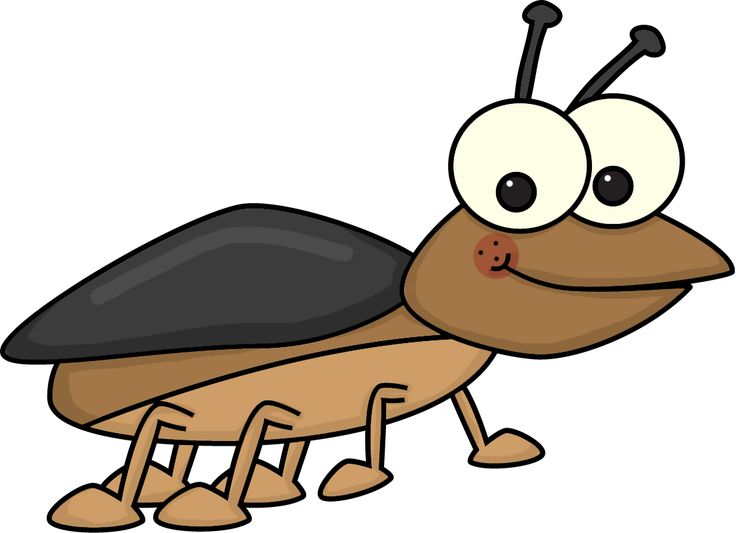

**Step 1: Import all libraries**

In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
import plotly
import plotly.express as px
import plotly.offline as pyo
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
%matplotlib inline

**Step 2: import data**

In [4]:
# Data is from a kaggle competition on vector-borne diseases
# https://www.kaggle.com/competitions/playground-series-s3e13
# This is the training data
df = pd.read_csv('train.csv')
df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever


In [5]:
# This is the test data to use for predictions / it has no prognosis column, just symptoms and an id
test = pd.read_csv('test.csv')
test.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,708,1,1,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,709,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,710,0,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,711,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


**Step 3: Data Exploration**

In [6]:
# Checking the shape and keys of the training dataset
df.shape

(707, 66)

In [7]:
# Checking data types of the training dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     707 non-null    int64  
 1   sudden_fever           707 non-null    float64
 2   headache               707 non-null    float64
 3   mouth_bleed            707 non-null    float64
 4   nose_bleed             707 non-null    float64
 5   muscle_pain            707 non-null    float64
 6   joint_pain             707 non-null    float64
 7   vomiting               707 non-null    float64
 8   rash                   707 non-null    float64
 9   diarrhea               707 non-null    float64
 10  hypotension            707 non-null    float64
 11  pleural_effusion       707 non-null    float64
 12  ascites                707 non-null    float64
 13  gastro_bleeding        707 non-null    float64
 14  swelling               707 non-null    float64
 15  nausea

In [8]:
# Finding unique values for all columns
df.nunique(axis = 0) # There are 64 symptoms (with boolean-like values/either you have a symptom or you don't), 1 id column (which represents a set of particular symptoms i.e., a patient), and 1 prognosis column with 11 possible disease outcomes

id                707
sudden_fever        2
headache            2
mouth_bleed         2
nose_bleed          2
                 ... 
ulcers              2
toenail_loss        2
speech_problem      2
bullseye_rash       2
prognosis          11
Length: 66, dtype: int64

**Step 4: Graphing & Visualizations**

In [77]:
# Rough look at data grouped by prognosis column and by sum of id #'s
df_group = df.groupby('prognosis').count()
df_group = df.reset_index() # reset index when graphing

# pyo.init_notebook_mode()
fig = px.histogram(df_group, x = 'prognosis', y = 'id', color = 'prognosis')

# fig = go.Figure(data=[go.Histogram(x=df_group['prognosis'])])
# data = go.Histogram(x=df_group['prognosis'], y=df_group['id'])
# pyo.iplot({ "data": data,"layout": go.Layout(title="vbd")})

fig.show(renderer="colab")

In [10]:
Xnew = df # saving original training df before the encoding step

df2 = df.drop(['id'], axis = 'columns')
df2 # dropping the 'id' column of original training data

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lyme_disease
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tungiasis
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,Lyme_disease
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,Rift_Valley_fever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Plague
703,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Malaria
704,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Zika
705,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,Plague


<Axes: xlabel='prognosis', ylabel='Frequency'>

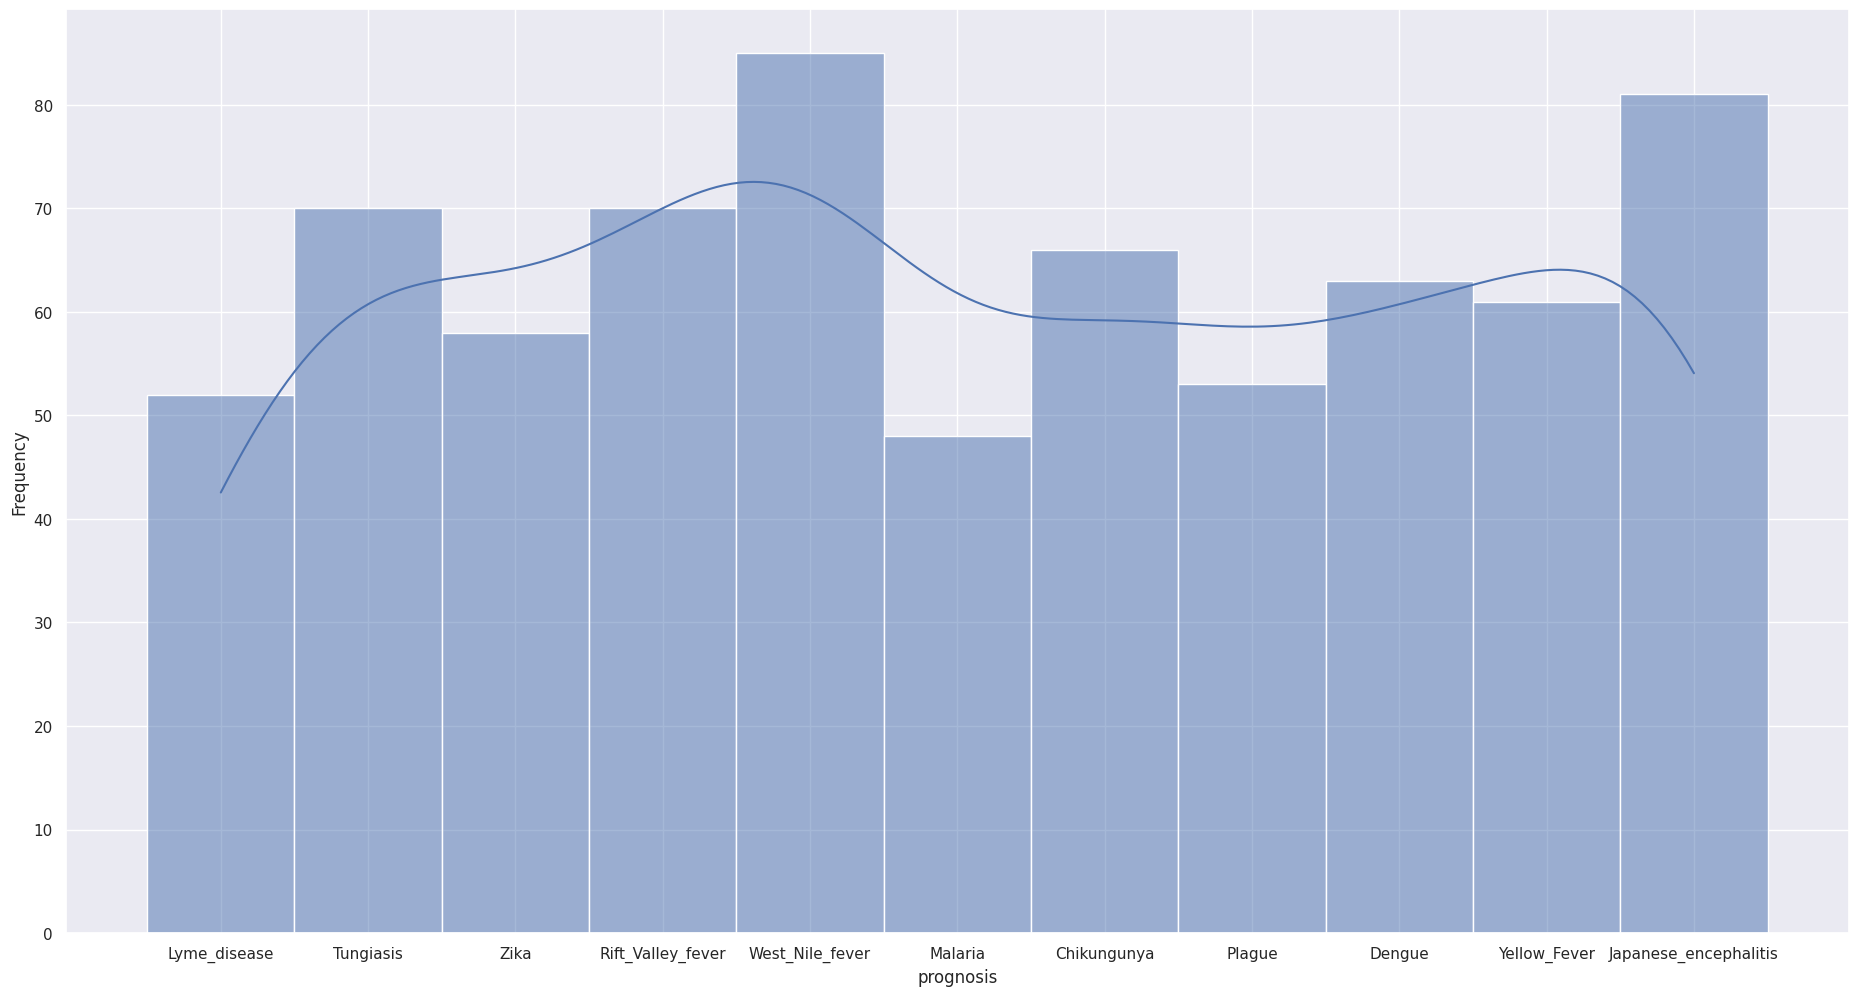

In [11]:
# Visualizing the frequency at which we see each prognosis (total unique prognosis = 11)
sns.set(rc={'figure.figsize':(23,12)}) #width=23, #height=12
sns.histplot(data = df2, x = 'prognosis',  stat = 'frequency', kde = True)

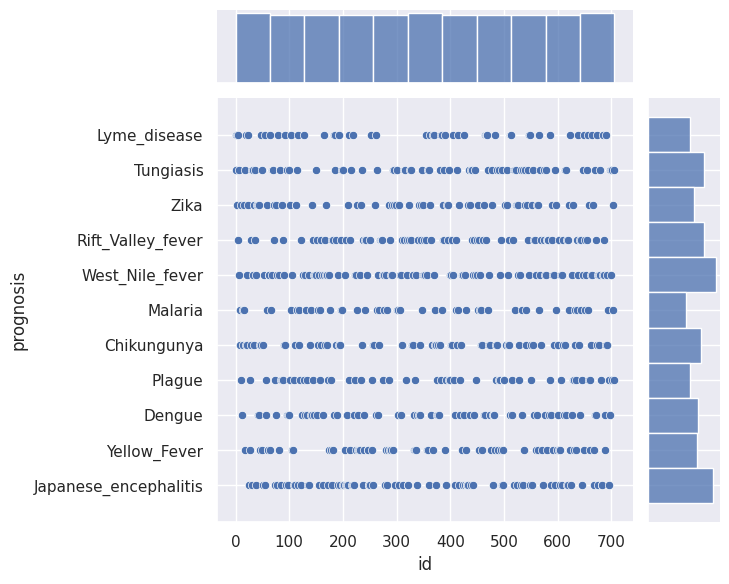

In [12]:
# Looking at prognosis vs. id based on original df that included the id column
sns.jointplot(data = df, x = 'id', y = 'prognosis')

In [13]:
# Another way to look at the data by group summing each symptom by prognosis
df2.groupby('prognosis').agg('sum') # df2 = dropped 'id' column

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
prognosis,,,,,,,,,,,,,,,,,,,,,
Chikungunya,40.0,37.0,34.0,45.0,39.0,38.0,35.0,41.0,24.0,6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dengue,26.0,23.0,34.0,35.0,30.0,34.0,27.0,34.0,26.0,26.0,...,13.0,1.0,6.0,3.0,6.0,19.0,19.0,14.0,2.0,4.0
Japanese_encephalitis,41.0,34.0,33.0,34.0,37.0,30.0,26.0,34.0,26.0,28.0,...,15.0,3.0,4.0,4.0,6.0,8.0,8.0,6.0,0.0,0.0
Lyme_disease,39.0,33.0,33.0,35.0,30.0,34.0,29.0,30.0,36.0,38.0,...,24.0,19.0,20.0,20.0,20.0,8.0,2.0,6.0,9.0,9.0
Malaria,31.0,28.0,29.0,29.0,27.0,34.0,31.0,34.0,30.0,26.0,...,7.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
Plague,27.0,26.0,22.0,27.0,34.0,26.0,21.0,27.0,20.0,25.0,...,5.0,5.0,6.0,5.0,6.0,1.0,1.0,1.0,2.0,1.0
Rift_Valley_fever,35.0,28.0,37.0,28.0,29.0,30.0,31.0,32.0,25.0,29.0,...,8.0,2.0,8.0,1.0,3.0,18.0,18.0,12.0,4.0,3.0
Tungiasis,16.0,21.0,16.0,14.0,22.0,19.0,25.0,19.0,16.0,14.0,...,7.0,5.0,4.0,5.0,3.0,43.0,43.0,46.0,2.0,1.0
West_Nile_fever,43.0,38.0,45.0,54.0,54.0,29.0,33.0,35.0,36.0,44.0,...,16.0,9.0,12.0,10.0,8.0,9.0,9.0,10.0,2.0,2.0


In [14]:
# Visualizing how often a vector-borne disease (x-axis) shows a sudden fever symptom / so West_Nile_fever has the highest occurence of a sudden fever
df2_group = df2.groupby('prognosis').agg('sum')
df2_group = df.reset_index()

fig2 = px.histogram(df2_group, x = 'prognosis', y = 'sudden_fever', color = 'prognosis')
fig2.show()

In [15]:
# Same thing as above but with bullseye rash / it highly occurs in lyme disease and not so much in the other vector-borne diseases
df2_group = df2.groupby('prognosis').agg('sum')
df2_group = df.reset_index()

fig3 = px.histogram(df2_group, x = 'prognosis', y = 'bullseye_rash', color = 'prognosis')
fig3.show()

In [16]:
# df2_flip = df2.T
# df2_flip

In [17]:
# df2_flip.reset_index(names = 'symptoms', inplace = True)

In [18]:
# df2_flip

**Step 5: Data Preprocessing**

In [19]:
# Encoding the prognosis column
le = LabelEncoder()
df['prognosis'] = le.fit_transform(df.prognosis)
df.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash,prognosis
0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3
3,3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,6


In [20]:
# Checking which encoded prognosis is which
df.groupby('prognosis').agg('sum')

# Based on the previous table up above, from here we can see that for prognosis:
# 0=Chikungunya, 1=Dengue, 2=Japanese_encephalitis, 3=Lyme_disease, 4=Malaria, 5=Plague, 6=Rift_Valley_fever, 7=Tungiasis, 8=West_Nile_fever, 9=Yellow_fever, 10=Zika

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
prognosis,,,,,,,,,,,,,,,,,,,,,
0,23042,40.0,37.0,34.0,45.0,39.0,38.0,35.0,41.0,24.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22257,26.0,23.0,34.0,35.0,30.0,34.0,27.0,34.0,26.0,...,13.0,1.0,6.0,3.0,6.0,19.0,19.0,14.0,2.0,4.0
2,27483,41.0,34.0,33.0,34.0,37.0,30.0,26.0,34.0,26.0,...,15.0,3.0,4.0,4.0,6.0,8.0,8.0,6.0,0.0,0.0
3,17932,39.0,33.0,33.0,35.0,30.0,34.0,29.0,30.0,36.0,...,24.0,19.0,20.0,20.0,20.0,8.0,2.0,6.0,9.0,9.0
4,16445,31.0,28.0,29.0,29.0,27.0,34.0,31.0,34.0,30.0,...,7.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
5,19247,27.0,26.0,22.0,27.0,34.0,26.0,21.0,27.0,20.0,...,5.0,5.0,6.0,5.0,6.0,1.0,1.0,1.0,2.0,1.0
6,26494,35.0,28.0,37.0,28.0,29.0,30.0,31.0,32.0,25.0,...,8.0,2.0,8.0,1.0,3.0,18.0,18.0,12.0,4.0,3.0
7,25604,16.0,21.0,16.0,14.0,22.0,19.0,25.0,19.0,16.0,...,7.0,5.0,4.0,5.0,3.0,43.0,43.0,46.0,2.0,1.0
8,29999,43.0,38.0,45.0,54.0,54.0,29.0,33.0,35.0,36.0,...,16.0,9.0,12.0,10.0,8.0,9.0,9.0,10.0,2.0,2.0


In [21]:
# Checking the prognosis column for encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     707 non-null    int64  
 1   sudden_fever           707 non-null    float64
 2   headache               707 non-null    float64
 3   mouth_bleed            707 non-null    float64
 4   nose_bleed             707 non-null    float64
 5   muscle_pain            707 non-null    float64
 6   joint_pain             707 non-null    float64
 7   vomiting               707 non-null    float64
 8   rash                   707 non-null    float64
 9   diarrhea               707 non-null    float64
 10  hypotension            707 non-null    float64
 11  pleural_effusion       707 non-null    float64
 12  ascites                707 non-null    float64
 13  gastro_bleeding        707 non-null    float64
 14  swelling               707 non-null    float64
 15  nausea

**Step 6: Identify inputs (X) and outputs (y)**

In [22]:
X = df.drop(['prognosis', 'id'], axis = 'columns')
X.head() # original training data

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [23]:
# Test data from competition / dropping the 'id' column / this test data does not include a 'prognosis' column since it will be used to predict that
X_data = test.drop(['id'], axis = 'columns')
X_data.head()

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,1,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Test data from competition / isolating the 'id' column for future predictions
X_data_id = test.id
X_data_id.head()

0    707
1    708
2    709
3    710
4    711
Name: id, dtype: int64

In [25]:
# Original training data / isolating the 'prognosis' column as the y-value
y = df.prognosis
y.head()

0     3
1     7
2     3
3    10
4     6
Name: prognosis, dtype: int64

**Step 7: model_params for GridSearchCV**

In [26]:
model_params = {
    'svm' : { # the name that you created to identify the model
        'model' : SVC(gamma = 'auto'), # this model is being fed to the GridSearchCV()
        'params' : { # those are the parameters you want to tune for
          'C' : [1, 10, 20],
          'kernel' : ['rbf', 'linear']
    }
  },
    'random_forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'n_estimators' : [10, 50, 100],
            'criterion' : ['gini'],
            'max_depth' : [50, 100, 200]
        }
    },
    'logisitc_regression' : {
        'model' : LogisticRegression(),
        'params' : {
            'C' : [1, 5, 10]
        }
    },
    'decision_tree' : {
        'model' : DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini'],
            'max_depth' : [5, 10, 20]
        }
    }
}

**Step 8: Do GridSearchCV**

In [27]:
scores = []
for model_name, mp in model_params.items():
  clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score = False)
  clf.fit(X, y)
  scores.append(
      { # only want the best scores & params for each model
      'model' : model_name,
      'best_score' : clf.best_score_,
      'best_params' : clf.best_params_
      }
  )

best_score = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
best_score

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

,model,best_score,best_params
0,svm,0.294276,"{'C': 20, 'kernel': 'rbf'}"
1,random_forest,0.309799,"{'criterion': 'gini', 'max_depth': 50, 'n_esti..."
2,logisitc_regression,0.287224,{'C': 1}
3,decision_tree,0.227700,"{'criterion': 'gini', 'max_depth': 5}"


**Step 9: Validate if random forest is actually a good model by using confusion matrix, precision, and recall**

In [28]:
# Creating the train_test_split to begin tuning the machine model / increased 'train_size' to 90%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state=42, shuffle=True)

In [29]:
# Quick look at shape of data / total 707 rows
print(X_train.shape)
print(X_test.shape)

(636, 64)
(71, 64)


**Step 10: Use PCA to reduce dimensions**

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, train_size = 0.9, random_state = 42, shuffle=True)

pca = PCA(0.95)
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, train_size = 0.9, random_state = 42, shuffle=True)

(707, 53)


In [31]:
pca.explained_variance_

array([11.40216212,  5.70921574,  3.26578529,  2.36962349,  2.22965855,
        1.92611314,  1.44547919,  1.27144339,  1.17640876,  1.16168763,
        1.11108265,  1.05340196,  1.03857111,  0.98076482,  0.95730611,
        0.94621902,  0.91079834,  0.90588045,  0.87400031,  0.86539995,
        0.82458158,  0.80679881,  0.79692127,  0.7743408 ,  0.76421361,
        0.75001814,  0.73097795,  0.71353361,  0.7059847 ,  0.69172049,
        0.67083806,  0.65369411,  0.64859922,  0.62970439,  0.62011418,
        0.6093466 ,  0.59121815,  0.57148062,  0.55178514,  0.54899823,
        0.51384796,  0.50192183,  0.49345363,  0.49294932,  0.47257429,
        0.46570872,  0.46517773,  0.4518309 ,  0.43166644,  0.41360882,
        0.40730402,  0.39849559,  0.36882343])

In [32]:
pca.explained_variance_ratio_

array([0.17790679, 0.08908032, 0.05095572, 0.036973  , 0.03478914,
       0.03005295, 0.02255367, 0.0198382 , 0.01835539, 0.0181257 ,
       0.01733611, 0.01643612, 0.01620472, 0.01530278, 0.01493675,
       0.01476376, 0.0142111 , 0.01413436, 0.01363694, 0.01350275,
       0.01286586, 0.0125884 , 0.01243428, 0.01208196, 0.01192395,
       0.01170246, 0.01140538, 0.01113319, 0.01101541, 0.01079285,
       0.01046702, 0.01019952, 0.01012003, 0.00982521, 0.00967558,
       0.00950757, 0.00922472, 0.00891675, 0.00860945, 0.00856596,
       0.00801752, 0.00783144, 0.00769931, 0.00769144, 0.00737353,
       0.00726641, 0.00725812, 0.00704987, 0.00673525, 0.0064535 ,
       0.00635512, 0.00621769, 0.00575471])

In [33]:
pca.explained_variance_ratio_.cumsum()

array([0.17790679, 0.26698711, 0.31794283, 0.35491583, 0.38970497,
       0.41975792, 0.44231158, 0.46214979, 0.48050517, 0.49863087,
       0.51596698, 0.53240311, 0.54860783, 0.5639106 , 0.57884735,
       0.59361111, 0.60782221, 0.62195657, 0.63559351, 0.64909626,
       0.66196212, 0.67455052, 0.6869848 , 0.69906677, 0.71099071,
       0.72269317, 0.73409855, 0.74523174, 0.75624715, 0.76703999,
       0.77750701, 0.78770654, 0.79782657, 0.80765178, 0.81732736,
       0.82683493, 0.83605965, 0.8449764 , 0.85358585, 0.86215182,
       0.87016934, 0.87800077, 0.88570008, 0.89339152, 0.90076505,
       0.90803145, 0.91528957, 0.92233945, 0.92907469, 0.93552819,
       0.94188332, 0.948101  , 0.95385572])

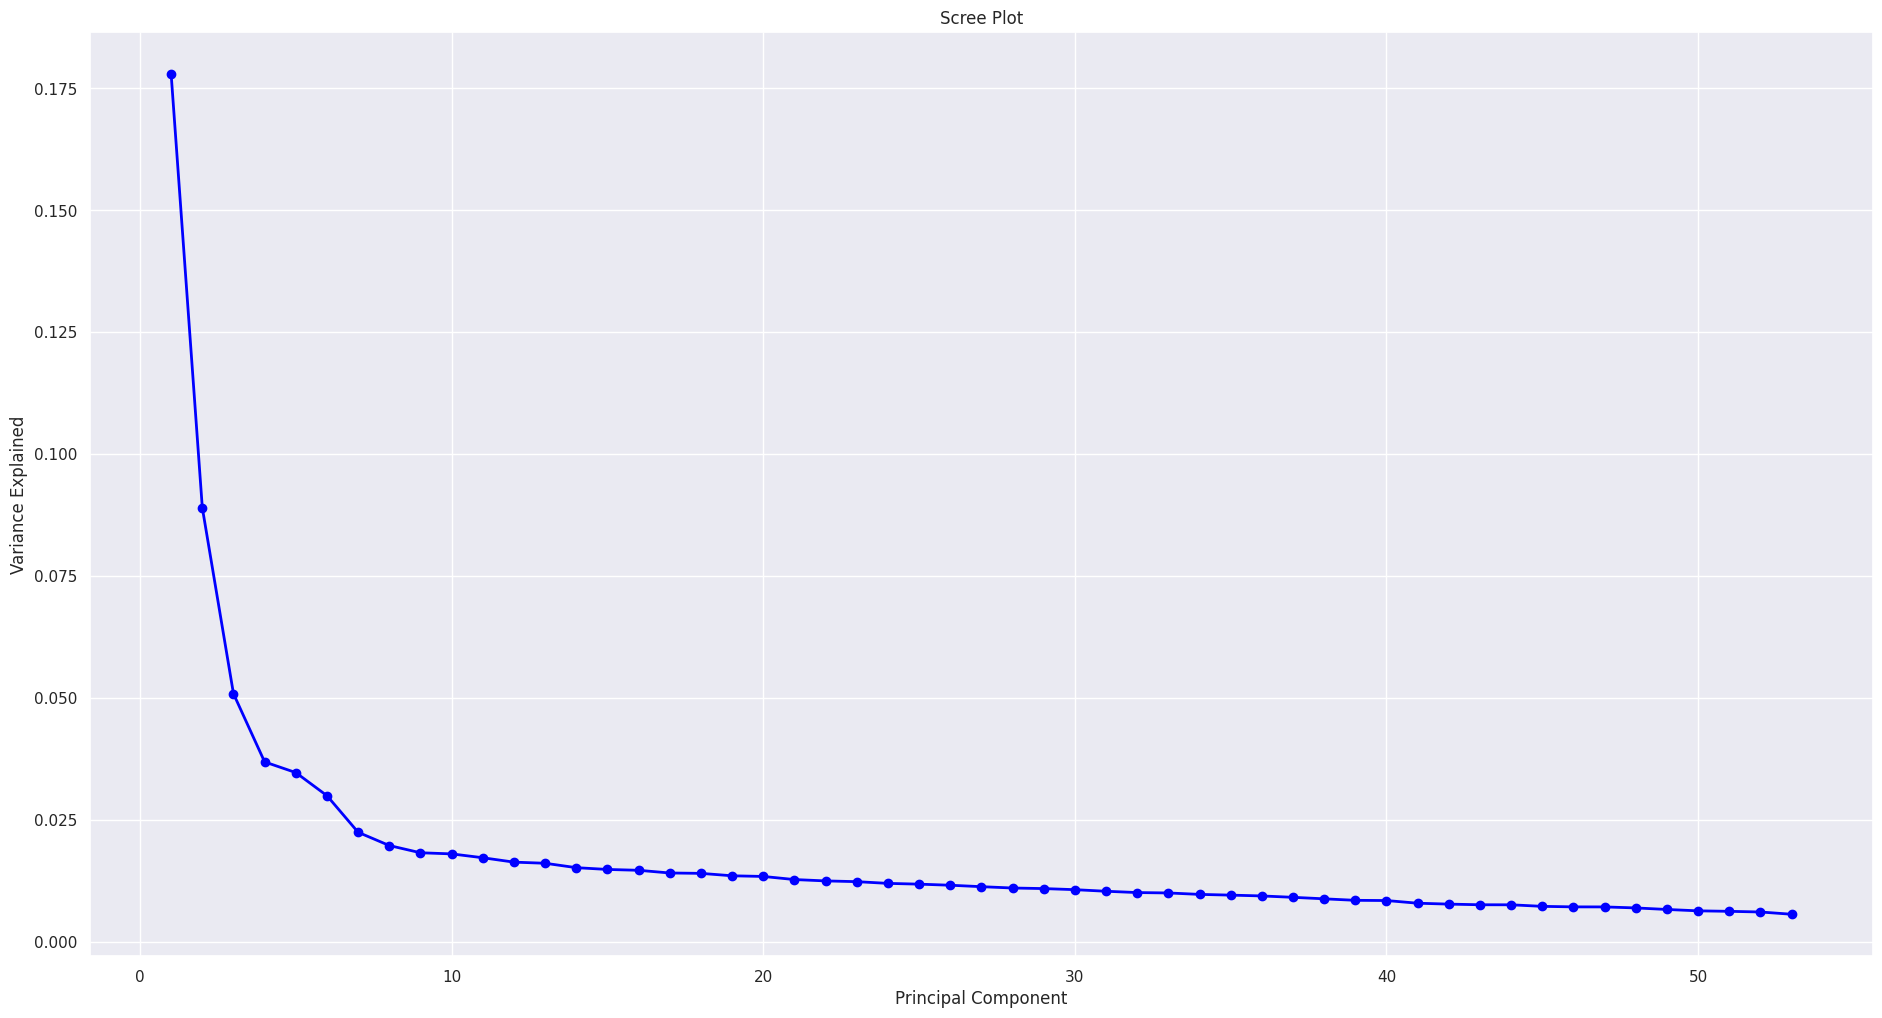

In [34]:
# Visualizing the PCA with a Scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [35]:
pca.n_components_

53

In [36]:
# Checking shape of pca data / We went from 64 columns to 53, so 53 columns explain 95% of the variance in my data
print(X_train_pca.shape)
print(X_test_pca.shape)

(636, 53)
(71, 53)


In [37]:
# Using this for the 'classification_report'
target_names = ['0.Chikungunya', '1.Dengue', '2.Japanese_encephalitis', '3.Lyme_disease', '4.Malaria', '5.Plague', '6.Rift_Valley_fever', '7.Tungiasis', '8.West_Nile_fever', '9.Yellow_fever', '10.Zika']

**Step 11.1 SVC: RBF Kernel Model**

 >RBF kernel is an okay model despite the high train score % potentially indicating an overfit model. It has the highest accuracy % of all the models at 38% which I think may be reasonable given the type of data. Precision (# of positives) and recall (total correctness of all positives/target class) are both 38% and I, again, think that's reasonable.

 >I added 'random_state' to keep my results consistent.

RBF Model Test Score: 0.38028169014084506
RBF Model Train Score: 0.7783018867924528
RBF Model Precision Score: 0.38028169014084506
RBF Model Recall Score: 0.38028169014084506
                         precision    recall  f1-score   support

          0.Chikungunya       0.56      0.83      0.67         6
               1.Dengue       0.40      0.50      0.44         4
2.Japanese_encephalitis       0.25      0.12      0.17         8
         3.Lyme_disease       0.67      0.67      0.67         6
              4.Malaria       0.33      0.33      0.33         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.33      0.11      0.17         9
            7.Tungiasis       0.62      1.00      0.77         5
      8.West_Nile_fever       0.27      0.36      0.31        11
         9.Yellow_fever       0.30      0.60      0.40         5
                10.Zika       0.00      0.00      0.00         3

               accuracy                    

Text(0.5, 1.0, 'SVC: RBF Kernel Confusion Matrix')

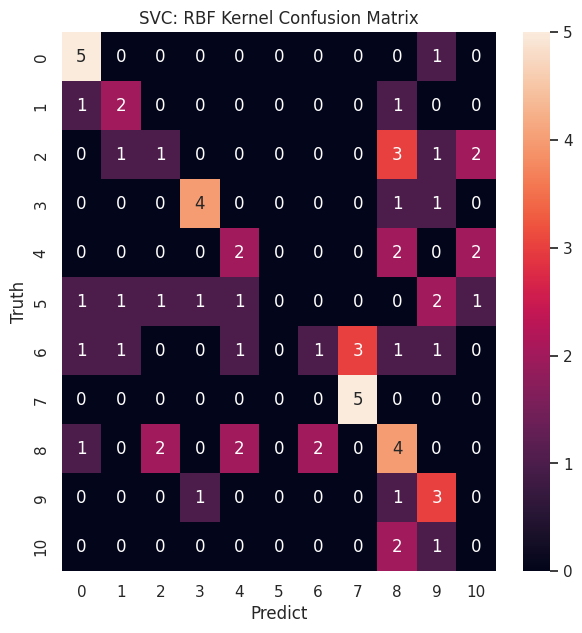

In [38]:
model_rbf = SVC(kernel='rbf', random_state=42)
model_rbf.fit(X_train, y_train)
print('RBF Model Test Score: '+ str(model_rbf.score(X_test, y_test)))

# Looking at the score of the training data vs. the test data for overfitting
print('RBF Model Train Score: ' + str(model_rbf.score(X_train, y_train)))

y_pred_rbf = model_rbf.predict(X_test)

precision_rbf = sm.precision_score(y_test, y_pred_rbf, average = 'micro')
print('RBF Model Precision Score: ' + str(precision_rbf))
recall_rbf = sm.recall_score(y_test, y_pred_rbf, average = 'micro')
print('RBF Model Recall Score: ' + str(recall_rbf))

print(classification_report(y_test, y_pred_rbf, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('SVC: RBF Kernel Confusion Matrix')

**Step 11.2 SVC: PCA RBF Kernel Model**

>No real differences with PCA data.

PCA RBF Model Test Score: 0.36619718309859156
PCA RBF Model Train Score: 0.7657232704402516
PCA RBF Model Precision Score: 0.36619718309859156
PCA RBF Model Recall Score: 0.36619718309859156
                         precision    recall  f1-score   support

          0.Chikungunya       0.56      0.83      0.67         6
               1.Dengue       0.20      0.25      0.22         4
2.Japanese_encephalitis       0.00      0.00      0.00         8
         3.Lyme_disease       0.80      0.67      0.73         6
              4.Malaria       0.29      0.33      0.31         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.43      0.33      0.38         9
            7.Tungiasis       0.62      1.00      0.77         5
      8.West_Nile_fever       0.27      0.27      0.27        11
         9.Yellow_fever       0.30      0.60      0.40         5
                10.Zika       0.00      0.00      0.00         3

               accuracy    

Text(0.5, 1.0, 'SVC: PCA RBF Kernel Confusion Matrix')

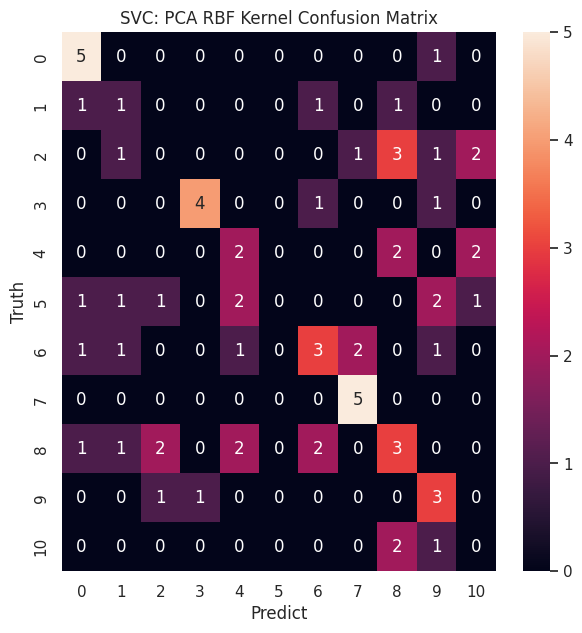

In [39]:
model_rbf_pca = SVC(kernel='rbf', random_state=42)
model_rbf_pca.fit(X_train_pca, y_train_pca)
print('PCA RBF Model Test Score: ' + str(model_rbf_pca.score(X_test_pca, y_test_pca)))

# Looking at the score of the training data vs. the test data for overfitting
print('PCA RBF Model Train Score: ' + str(model_rbf_pca.score(X_train_pca, y_train_pca)))

y_pred_rbf_pca = model_rbf_pca.predict(X_test_pca)

precision_rbf_pca = sm.precision_score(y_test_pca, y_pred_rbf_pca, average = 'micro')
print('PCA RBF Model Precision Score: ' + str(precision_rbf_pca))
recall_rbf_pca = sm.recall_score(y_test_pca, y_pred_rbf_pca, average = 'micro')
print('PCA RBF Model Recall Score: ' + str(recall_rbf_pca))

print(classification_report(y_test_pca, y_pred_rbf_pca, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test_pca, y_pred_rbf_pca)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('SVC: PCA RBF Kernel Confusion Matrix')

**Step 12.1 Random Forest Classifier Model**

 >Random forest is an okay model, it has a 35% accuracy score and a much better train score of 38%. The train score was originally 100% when I had used 80% training data. When I moved the training data % up to 90%, I got much better results and corrected the overfitting that was really bad on this model (as well as the others). I think the precision (# of positives) and recall (total correctness of all positives/target class) are both 35% and reasonable. This one and RBF were both good models.

 >I added 'random_state' to keep my results consistent as well as other parameters that I manually tuned to get these results.

RFC Model Test Score: 0.352112676056338
RFC Model Train Score: 0.3836477987421384
RFC Model Precision Score: 0.352112676056338
RFC Model Recall Score: 0.352112676056338
                         precision    recall  f1-score   support

          0.Chikungunya       0.38      0.83      0.53         6
               1.Dengue       0.00      0.00      0.00         4
2.Japanese_encephalitis       0.22      0.25      0.24         8
         3.Lyme_disease       0.60      0.50      0.55         6
              4.Malaria       0.00      0.00      0.00         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.50      0.11      0.18         9
            7.Tungiasis       0.45      1.00      0.62         5
      8.West_Nile_fever       0.35      0.55      0.43        11
         9.Yellow_fever       0.25      0.60      0.35         5
                10.Zika       0.00      0.00      0.00         3

               accuracy                          

Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix')

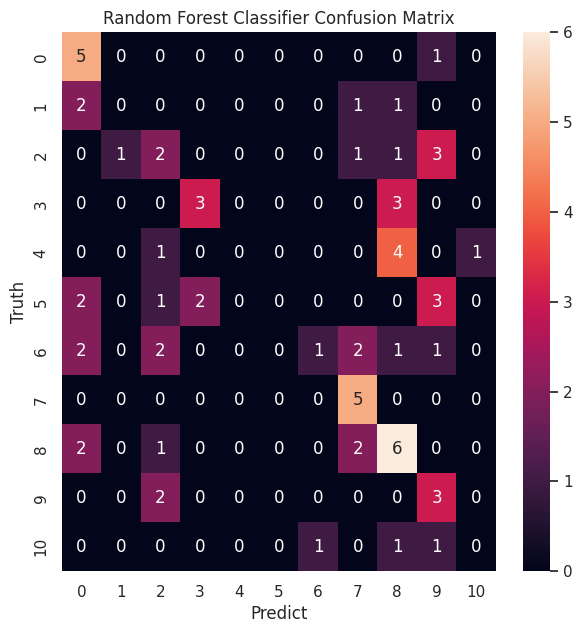

In [40]:
model_rfc = RandomForestClassifier(n_estimators = 5000, random_state=42, max_depth=10, max_leaf_nodes=7)
model_rfc.fit(X_train, y_train)
print('RFC Model Test Score: ' + str(model_rfc.score(X_test, y_test)))

# Looking at the score of the training data vs. the test data for overfitting
print('RFC Model Train Score: ' + str(model_rfc.score(X_train, y_train)))

y_pred_rfc = model_rfc.predict(X_test)

precision_rfc = sm.precision_score(y_test, y_pred_rfc, average = 'micro')
print('RFC Model Precision Score: ' + str(precision_rfc))
recall_rfc = sm.recall_score(y_test, y_pred_rfc, average = 'micro')
print('RFC Model Recall Score: ' + str(recall_rfc))

print(classification_report(y_test, y_pred_rfc, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('Random Forest Classifier Confusion Matrix')

**Step 12.2 PCA Random Forest Classifier Model**

>No real difference, I think some false predictions went up even though the accuracy score technically increased so I don't think its a better model with PCA.

PCA RFC Model Test Score: 0.36619718309859156
PCA RFC Model Train Score: 0.47641509433962265
PCA RFC Model Precision Score: 0.36619718309859156
PCA RFC Model Recall Score: 0.36619718309859156
                         precision    recall  f1-score   support

          0.Chikungunya       0.56      0.83      0.67         6
               1.Dengue       1.00      0.25      0.40         4
2.Japanese_encephalitis       0.24      0.50      0.32         8
         3.Lyme_disease       0.60      0.50      0.55         6
              4.Malaria       0.33      0.33      0.33         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       1.00      0.11      0.20         9
            7.Tungiasis       0.56      1.00      0.71         5
      8.West_Nile_fever       0.22      0.36      0.28        11
         9.Yellow_fever       0.20      0.20      0.20         5
                10.Zika       0.00      0.00      0.00         3

               accuracy   

Text(0.5, 1.0, 'PCA Random Forest Classifier Confusion Matrix')

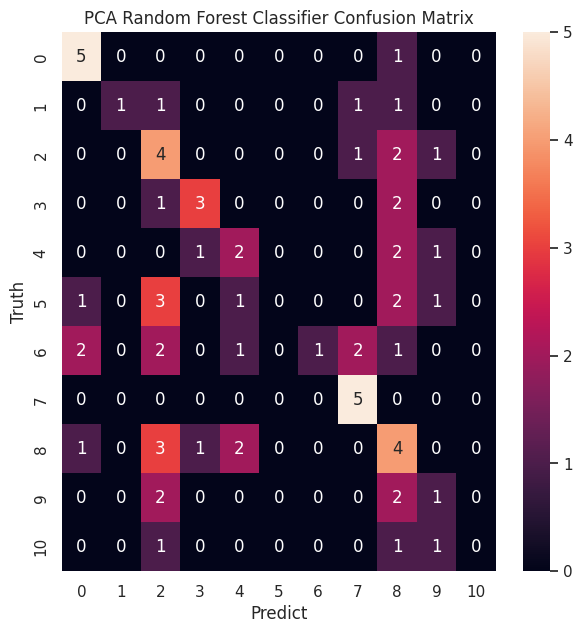

In [41]:
model_rfc_pca = RandomForestClassifier(n_estimators = 5000, random_state=42, max_depth=10, max_leaf_nodes=7)
model_rfc_pca.fit(X_train_pca, y_train_pca)
print('PCA RFC Model Test Score: ' + str(model_rfc_pca.score(X_test_pca, y_test_pca)))

# Looking at the score of the training data vs. the test data for overfitting
print('PCA RFC Model Train Score: ' + str(model_rfc_pca.score(X_train_pca, y_train_pca)))

y_pred_rfc_pca = model_rfc_pca.predict(X_test_pca)

precision_rfc_pca = sm.precision_score(y_test_pca, y_pred_rfc_pca, average = 'micro')
print('PCA RFC Model Precision Score: ' + str(precision_rfc_pca))
recall_rfc_pca = sm.recall_score(y_test_pca, y_pred_rfc_pca, average = 'micro')
print('PCA RFC Model Recall Score: ' + str(recall_rfc_pca))

print(classification_report(y_test_pca, y_pred_rfc_pca, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test_pca, y_pred_rfc_pca)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('PCA Random Forest Classifier Confusion Matrix')

**Step 13.1 Logistic Regression Model**

 >Logistic regression is an okay model as well. It has a 37% accuracy score and I think the train % score is okay at 53%. Not bad, not great. Precision and recall are okay at 38% each.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LR Model Test Score: 0.36619718309859156
LR Model Train Score: 0.5361635220125787
LR Model Precision Score: 0.3810606060606061
LR Model Recall Score: 0.3810606060606061
                         precision    recall  f1-score   support

          0.Chikungunya       0.71      0.83      0.77         6
               1.Dengue       0.29      0.50      0.36         4
2.Japanese_encephalitis       0.29      0.25      0.27         8
         3.Lyme_disease       0.80      0.67      0.73         6
              4.Malaria       0.20      0.17      0.18         6
               5.Plague       0.40      0.25      0.31         8
    6.Rift_Valley_fever       0.29      0.22      0.25         9
            7.Tungiasis       0.67      0.80      0.73         5
      8.West_Nile_fever       0.29      0.18      0.22        11
         9.Yellow_fever       0.14      0.20      0.17         5
                10.Zika       0.12      0.33      0.18         3

               accuracy                          

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

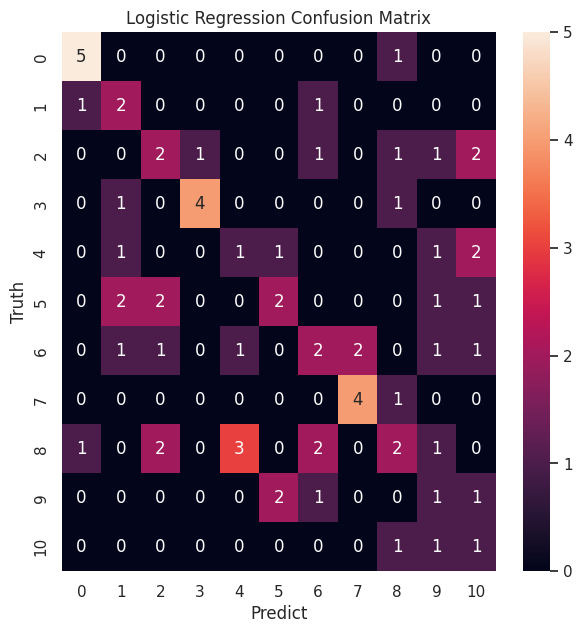

In [42]:
model_lr = LogisticRegression(multi_class='multinomial')
model_lr.fit(X_train, y_train)
print('LR Model Test Score: ' + str(model_lr.score(X_test, y_test)))

# Looking at the score of the training data vs. the test data for overfitting
print('LR Model Train Score: ' + str(model_lr.score(X_train, y_train)))

y_pred_lr = model_lr.predict(X_test)

precision_lr = sm.precision_score(y_test, y_pred_lr, average = 'macro')
print('LR Model Precision Score: ' + str(precision_lr))
recall_lr = sm.precision_score(y_test, y_pred_lr, average = 'macro')
print('LR Model Recall Score: ' + str(recall_lr))

print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('Logistic Regression Confusion Matrix')

**Step 13.2 PCA Logistic Regression Model**

>I think there was also an increase in false predictions with the PCA data as well as a drop in the accuracy, precision, and recall scores which is now at 28%, 31%, and 30%, respectively. So, this model is not better with the PCA.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



PCA LR Model Test Score: 0.28169014084507044
PCA LR Model Train Score: 0.5172955974842768
PCA LR Model Precision Score: 0.3181818181818181
PCA LR Model Recall Score: 0.3076905417814509
                         precision    recall  f1-score   support

          0.Chikungunya       0.71      0.83      0.77         6
               1.Dengue       0.12      0.25      0.17         4
2.Japanese_encephalitis       0.17      0.12      0.14         8
         3.Lyme_disease       1.00      0.50      0.67         6
              4.Malaria       0.00      0.00      0.00         6
               5.Plague       0.33      0.25      0.29         8
    6.Rift_Valley_fever       0.14      0.11      0.12         9
            7.Tungiasis       0.50      0.60      0.55         5
      8.West_Nile_fever       0.25      0.18      0.21        11
         9.Yellow_fever       0.14      0.20      0.17         5
                10.Zika       0.12      0.33      0.18         3

               accuracy          

Text(0.5, 1.0, 'PCA Logisitc Regression Confusion Matrix')

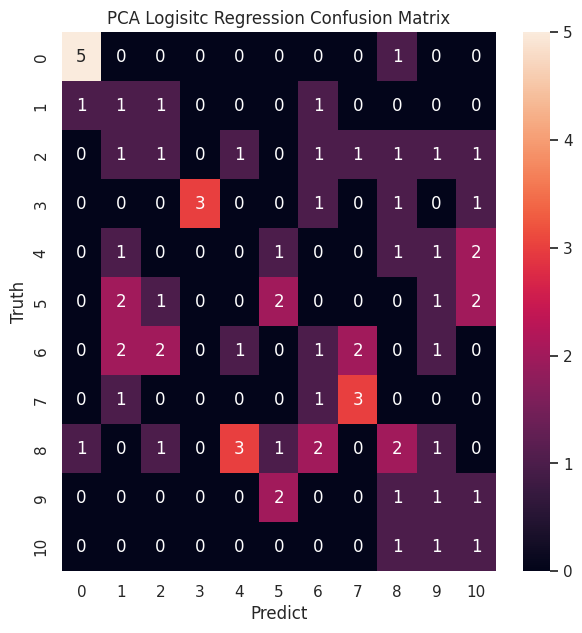

In [43]:
model_lr_pca = LogisticRegression(multi_class='multinomial')
model_lr_pca.fit(X_train_pca, y_train_pca)
print('PCA LR Model Test Score: ' + str(model_lr_pca.score(X_test_pca, y_test_pca)))

# Looking at the score of the training data vs. the test data for overfitting
print('PCA LR Model Train Score: ' + str(model_lr_pca.score(X_train_pca, y_train_pca)))

y_pred_lr_pca = model_lr_pca.predict(X_test_pca)

precision_lr_pca = sm.precision_score(y_test_pca, y_pred_lr_pca, average = 'macro')
print('PCA LR Model Precision Score: ' + str(precision_lr_pca))
recall_lr_pca = sm.recall_score(y_test_pca, y_pred_lr_pca, average = 'macro')
print('PCA LR Model Recall Score: ' + str(recall_lr_pca))

print(classification_report(y_test_pca, y_pred_lr_pca, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test_pca, y_pred_lr_pca) # maybe changed y_test
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('PCA Logisitc Regression Confusion Matrix')

**Step 14.1 Decision Tree Classifier Model**

>Decision Tree is not a good model to me. Despite a fairly decent test, precision, recall, and accuracy score all at 35%. It has a higher false prediction rate shown by the heatmap/confusion matrix. This model had a very high train % score, indicatting overfitting, before I tuned it down by setting the 'max_depth=' parameter to 6. The 'criterion=' param made only a small difference.

DTC Model Test Score: 0.352112676056338
DTC Model Train Score: 0.5031446540880503
DTC Model Precision Score: 0.352112676056338
DTC Model Recall Score: 0.352112676056338
                         precision    recall  f1-score   support

          0.Chikungunya       0.56      0.83      0.67         6
               1.Dengue       0.25      0.75      0.38         4
2.Japanese_encephalitis       0.00      0.00      0.00         8
         3.Lyme_disease       0.50      0.17      0.25         6
              4.Malaria       0.40      0.33      0.36         6
               5.Plague       0.38      0.38      0.38         8
    6.Rift_Valley_fever       0.20      0.11      0.14         9
            7.Tungiasis       0.80      0.80      0.80         5
      8.West_Nile_fever       0.33      0.09      0.14        11
         9.Yellow_fever       0.43      0.60      0.50         5
                10.Zika       0.50      0.67      0.57         3

               accuracy                          

Text(0.5, 1.0, 'Decision Tree Classifier Confusion Matrix')

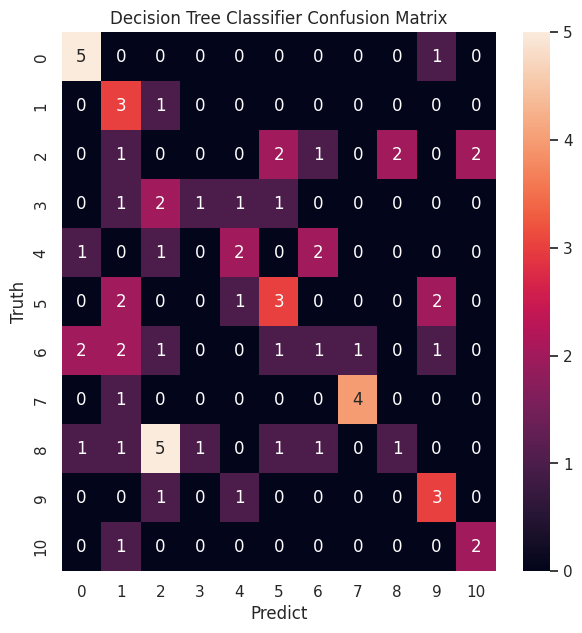

In [44]:
model_dtc = DecisionTreeClassifier(max_depth = 6, criterion='entropy')
model_dtc.fit(X_train, y_train)
print('DTC Model Test Score: ' + str(model_dtc.score(X_test, y_test)))

# Looking at the score of the training data vs. the test data for overfitting
print('DTC Model Train Score: ' + str(model_dtc.score(X_train, y_train)))

y_pred_dtc = model_dtc.predict(X_test)

precision_dtc = sm.precision_score(y_test, y_pred_dtc, average = 'micro')
print('DTC Model Precision Score: ' + str(precision_dtc))
recall_dtc = sm.recall_score(y_test, y_pred_dtc, average = 'micro')
print('DTC Model Recall Score: ' + str(recall_dtc))

print(classification_report(y_test, y_pred_dtc, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_dtc)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('Decision Tree Classifier Confusion Matrix')

[Text(0.4969262295081967, 0.9285714285714286, 'x[37] <= 0.5\nentropy = 3.437\nsamples = 636\nvalue = [60, 59, 73, 46, 42, 45, 61, 65, 74, 56, 55]'),
 Text(0.25614754098360654, 0.7857142857142857, 'x[61] <= 0.5\nentropy = 3.217\nsamples = 327\nvalue = [56, 53, 27, 11, 11, 10, 43, 48, 33, 15, 20]'),
 Text(0.13114754098360656, 0.6428571428571429, 'x[27] <= 0.5\nentropy = 3.209\nsamples = 256\nvalue = [56, 40, 25, 10, 11, 10, 33, 10, 27, 14, 20]'),
 Text(0.06557377049180328, 0.5, 'x[19] <= 0.5\nentropy = 2.867\nsamples = 170\nvalue = [56, 32, 15, 1, 5, 3, 19, 6, 15, 8, 10]'),
 Text(0.03278688524590164, 0.35714285714285715, 'x[53] <= 0.5\nentropy = 2.503\nsamples = 130\nvalue = [55, 28, 9, 0, 3, 3, 14, 1, 8, 5, 4]'),
 Text(0.01639344262295082, 0.21428571428571427, 'x[9] <= 0.5\nentropy = 2.339\nsamples = 117\nvalue = [55, 27, 4, 0, 3, 3, 11, 1, 6, 3, 4]'),
 Text(0.00819672131147541, 0.07142857142857142, 'entropy = 1.951\nsamples = 86\nvalue = [51, 16, 2, 0, 0, 2, 5, 1, 4, 1, 4]'),
 Text(0.0

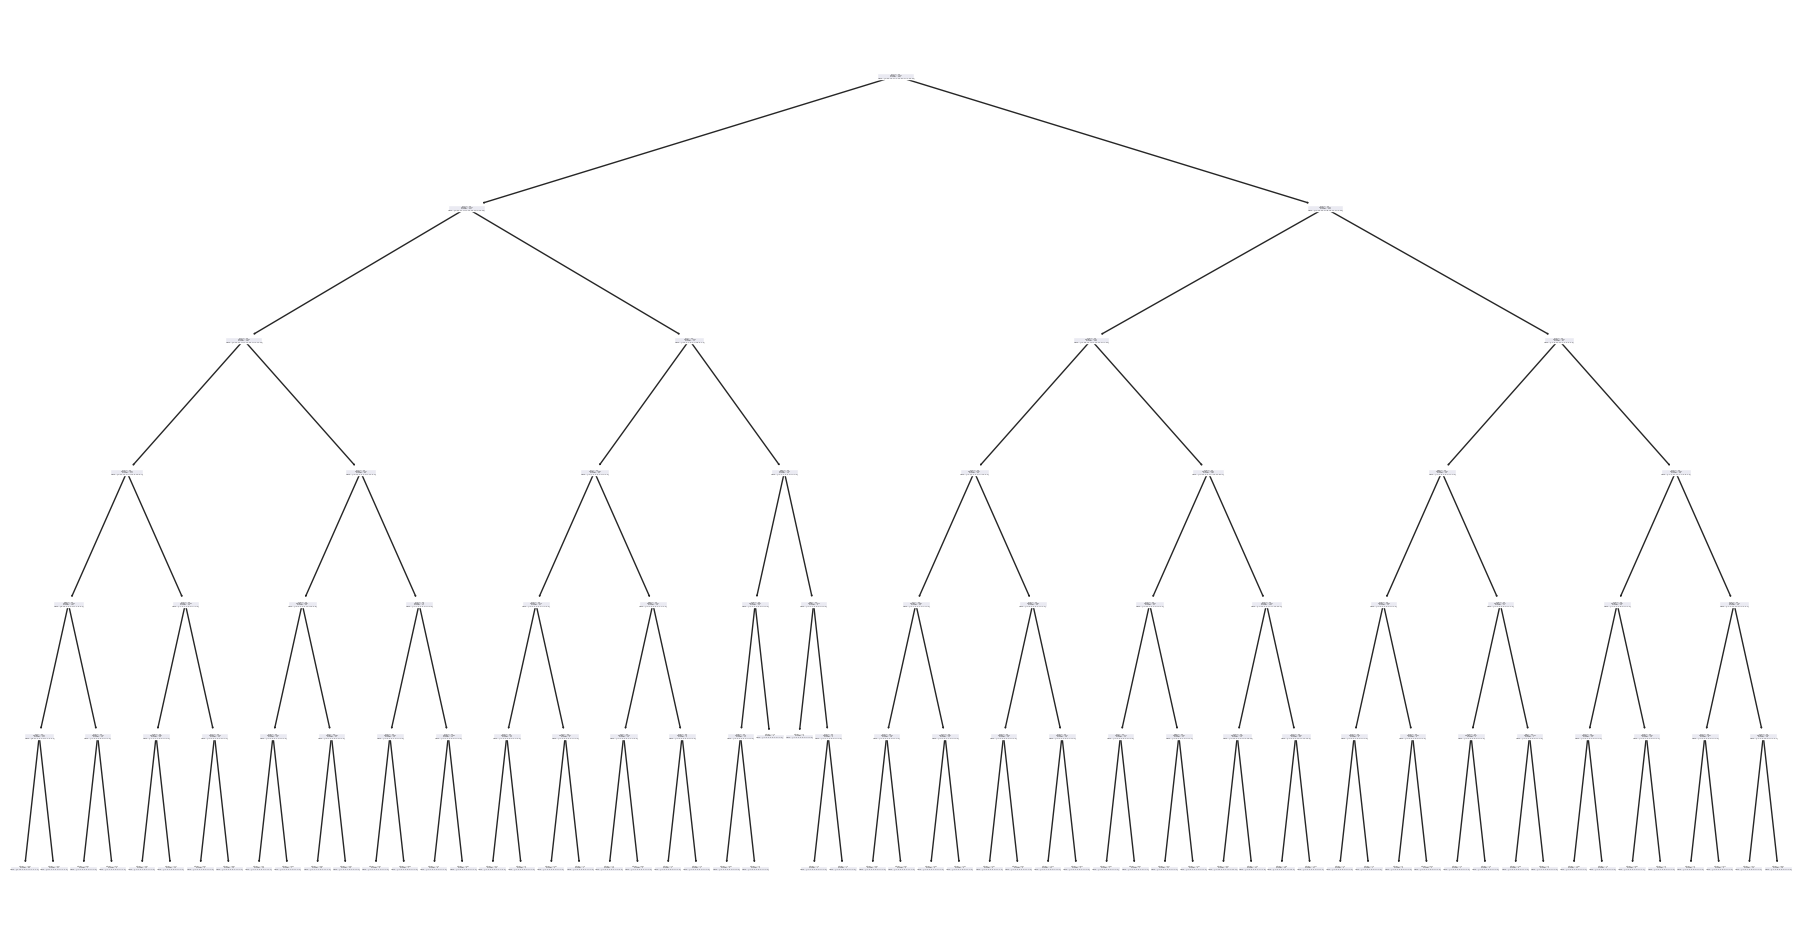

In [45]:
tree.plot_tree(model_dtc)

In [46]:
# model_dtc.feature_importances_ # total reduction of criteria by feature (Gini importance)

In [47]:
model_dtc.max_features_ # inferred value of max_features

64

**Step 14.2 PCA Decision Tree Classifier Model**

>PCA for Decision Tree was way worse. A drop in a lot of accuracy as well as the precision and recall. And many more false predictions.

PCA DTC Model Test Score: 0.2535211267605634
PCA DTC Model Train Score: 0.5047169811320755
PCA DTC Model Precision Score: 0.2535211267605634
PCA DTC Model Recall Score: 0.2535211267605634
                         precision    recall  f1-score   support

          0.Chikungunya       0.75      0.50      0.60         6
               1.Dengue       0.00      0.00      0.00         4
2.Japanese_encephalitis       0.09      0.12      0.11         8
         3.Lyme_disease       0.38      0.50      0.43         6
              4.Malaria       0.33      0.17      0.22         6
               5.Plague       0.33      0.25      0.29         8
    6.Rift_Valley_fever       0.12      0.11      0.12         9
            7.Tungiasis       0.75      0.60      0.67         5
      8.West_Nile_fever       0.20      0.27      0.23        11
         9.Yellow_fever       0.14      0.20      0.17         5
                10.Zika       0.00      0.00      0.00         3

               accuracy       

Text(0.5, 1.0, 'PCA Decision Tree Classifier Confusion Matrix')

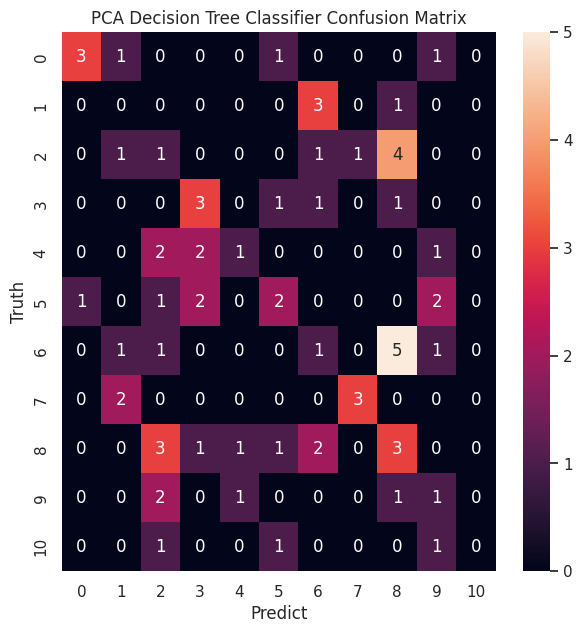

In [48]:
model_dtc_pca = DecisionTreeClassifier(max_depth = 6, criterion='entropy')
model_dtc_pca.fit(X_train_pca, y_train_pca)
print('PCA DTC Model Test Score: ' + str(model_dtc_pca.score(X_test_pca, y_test_pca)))

# Looking at the score of the training data vs. the test data for overfitting
print('PCA DTC Model Train Score: ' + str(model_dtc_pca.score(X_train_pca, y_train_pca)))

y_pred_dtc_pca = model_dtc_pca.predict(X_test_pca)

precision_dtc_pca = sm.precision_score(y_test_pca, y_pred_dtc_pca, average = 'micro')
print('PCA DTC Model Precision Score: ' + str(precision_dtc_pca))
recall_dtc_pca = sm.recall_score(y_test_pca, y_pred_dtc_pca, average = 'micro')
print('PCA DTC Model Recall Score: ' + str(recall_dtc_pca))

print(classification_report(y_test_pca, y_pred_dtc_pca, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test_pca, y_pred_dtc_pca)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('PCA Decision Tree Classifier Confusion Matrix')

[Text(0.4544836956521739, 0.9285714285714286, 'x[0] <= -2.707\nentropy = 3.437\nsamples = 636\nvalue = [60, 59, 73, 46, 42, 45, 61, 65, 74, 56, 55]'),
 Text(0.18885869565217392, 0.7857142857142857, 'x[3] <= -0.349\nentropy = 2.456\nsamples = 156\nvalue = [53, 29, 7, 0, 1, 3, 13, 40, 6, 4, 0]'),
 Text(0.10326086956521739, 0.6428571428571429, 'x[0] <= -3.618\nentropy = 1.723\nsamples = 81\nvalue = [52, 16, 3, 0, 1, 3, 2, 1, 1, 2, 0]'),
 Text(0.05434782608695652, 0.5, 'x[26] <= 0.301\nentropy = 0.941\nsamples = 55\nvalue = [44, 8, 0, 0, 0, 2, 0, 0, 1, 0, 0]'),
 Text(0.03260869565217391, 0.35714285714285715, 'x[5] <= -0.312\nentropy = 0.675\nsamples = 45\nvalue = [37, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.021739130434782608, 0.21428571428571427, 'x[16] <= 0.191\nentropy = 0.89\nsamples = 26\nvalue = [18, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.010869565217391304, 0.07142857142857142, 'entropy = 1.0\nsamples = 16\nvalue = [8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(0.03260869565217391, 0

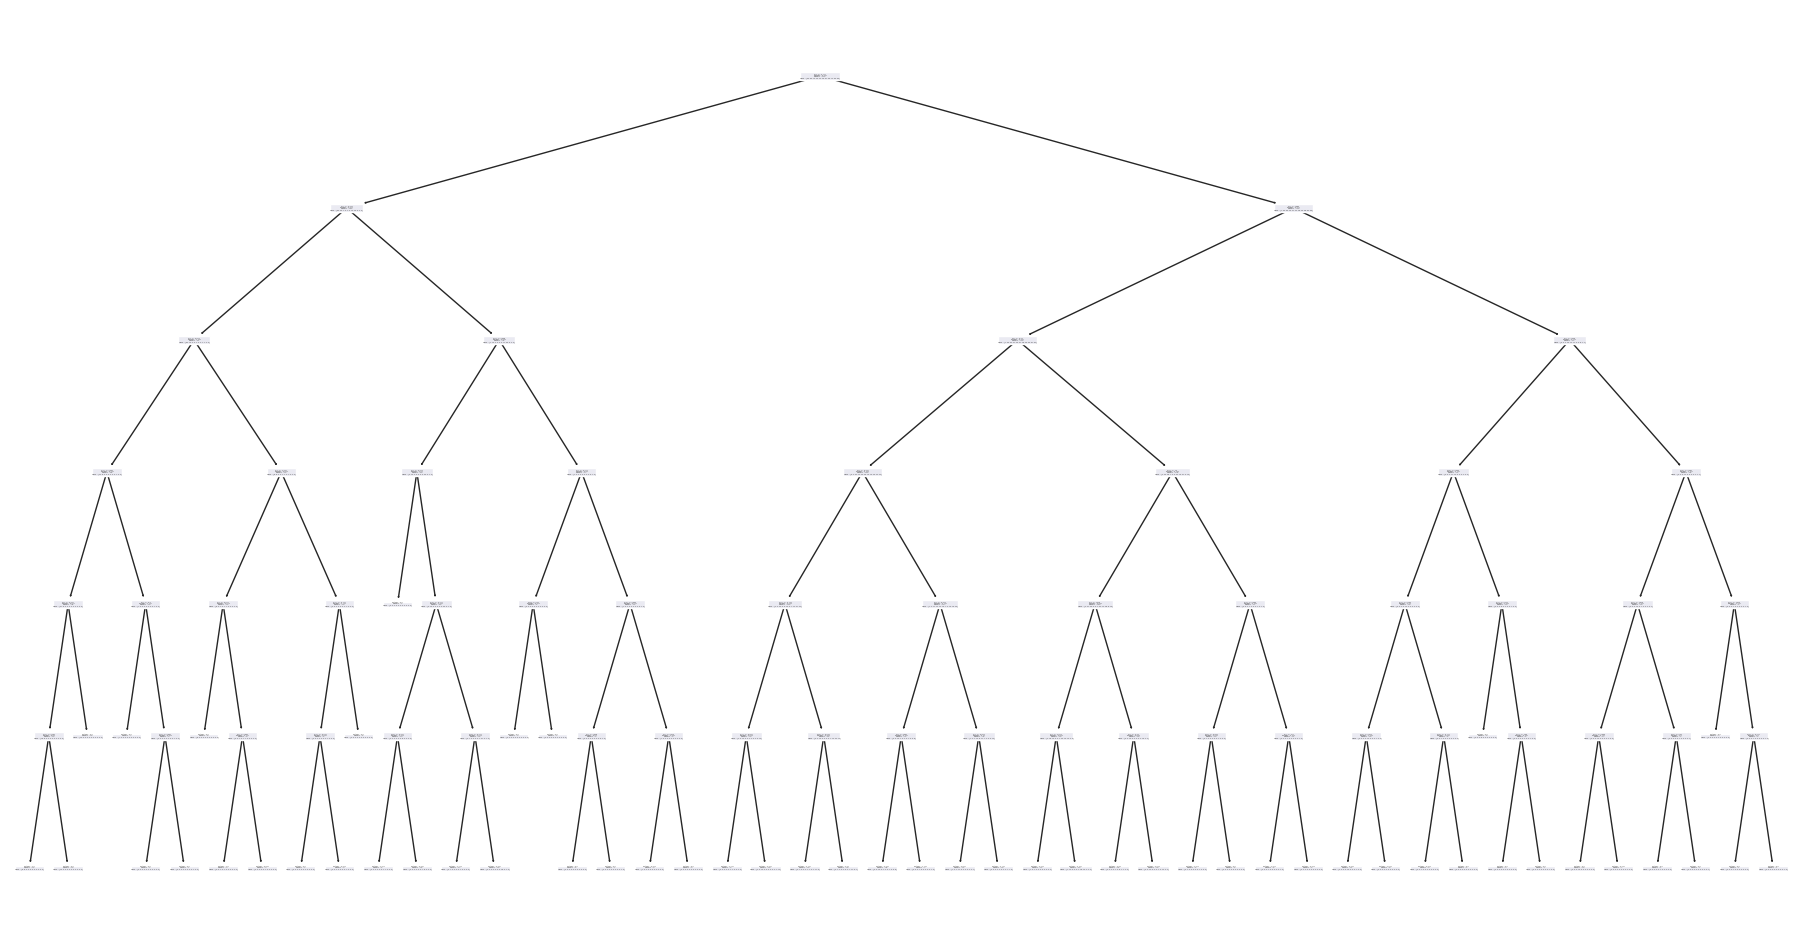

In [49]:
tree.plot_tree(model_dtc_pca)

In [50]:
# model_dtc_pca.feature_importances_ # total reduction of criteria by feature (Gini importance)

In [51]:
model_dtc_pca.max_features_ # inferred value of max_features

53

**Step 15.1 SVC: Linear Kernel Model**
>Linear Kernel is not a good model. With a test score of 32% and a train score of 74% I think the model is overfitted. Precision, recall, and accuracy are all decent numbers given the other models and the data but I think the train score % is too high. Not to mention the confusion matrix is also just not that great and has just a few too many false predicitons.

Linear Model Test Score: 0.323943661971831
Linear Model Train Score: 0.7437106918238994
Linear Model Precision Score: 0.31262626262626264
Linear Model Recall Score: 0.31262626262626264
                         precision    recall  f1-score   support

          0.Chikungunya       0.56      0.83      0.67         6
               1.Dengue       0.25      0.25      0.25         4
2.Japanese_encephalitis       0.30      0.38      0.33         8
         3.Lyme_disease       0.80      0.67      0.73         6
              4.Malaria       0.17      0.17      0.17         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.38      0.33      0.35         9
            7.Tungiasis       0.67      0.80      0.73         5
      8.West_Nile_fever       0.20      0.09      0.13        11
         9.Yellow_fever       0.12      0.20      0.15         5
                10.Zika       0.00      0.00      0.00         3

               accuracy          

Text(0.5, 1.0, 'SVC: Linear Kernel Confusion Matrix')

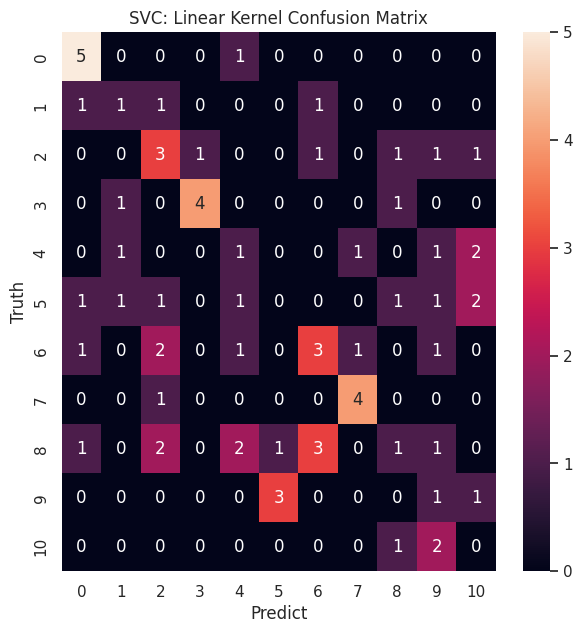

In [52]:
model_linear = SVC(kernel = 'linear')
model_linear.fit(X_train, y_train)
print('Linear Model Test Score: ' + str(model_linear.score(X_test, y_test)))

# Looking at the score of the training data vs. the test data for overfitting
print('Linear Model Train Score: ' + str(model_linear.score(X_train, y_train)))

y_pred_linear = model_linear.predict(X_test)

precision_linear = sm.precision_score(y_test, y_pred_linear, average = 'macro')
print('Linear Model Precision Score: ' + str(precision_linear))
recall_linear = sm.precision_score(y_test, y_pred_linear, average = 'macro')
print('Linear Model Recall Score: ' + str(recall_linear))

print(classification_report(y_test, y_pred_linear, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_linear)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('SVC: Linear Kernel Confusion Matrix')

**Step 15.2 SVC: PCA Linear Kernel Model**

>PCA is not any better and the train score even went up to 80% while the test score went down to 26%. Not a good model.

PCA Linear Model Test Score: 0.2676056338028169
PCA Linear Model Train Score: 0.809748427672956
PCA Linear Model Precision Score: 0.28347864967583275
PCA Linear Model Recall Score: 0.28347864967583275
                         precision    recall  f1-score   support

          0.Chikungunya       0.62      0.83      0.71         6
               1.Dengue       0.22      0.50      0.31         4
2.Japanese_encephalitis       0.17      0.12      0.14         8
         3.Lyme_disease       1.00      0.67      0.80         6
              4.Malaria       0.00      0.00      0.00         6
               5.Plague       0.17      0.12      0.14         8
    6.Rift_Valley_fever       0.33      0.22      0.27         9
            7.Tungiasis       0.25      0.20      0.22         5
      8.West_Nile_fever       0.14      0.09      0.11        11
         9.Yellow_fever       0.20      0.40      0.27         5
                10.Zika       0.00      0.00      0.00         3

               ac

Text(0.5, 1.0, 'SVC: PCA Linear Kernel Confusion Matrix')

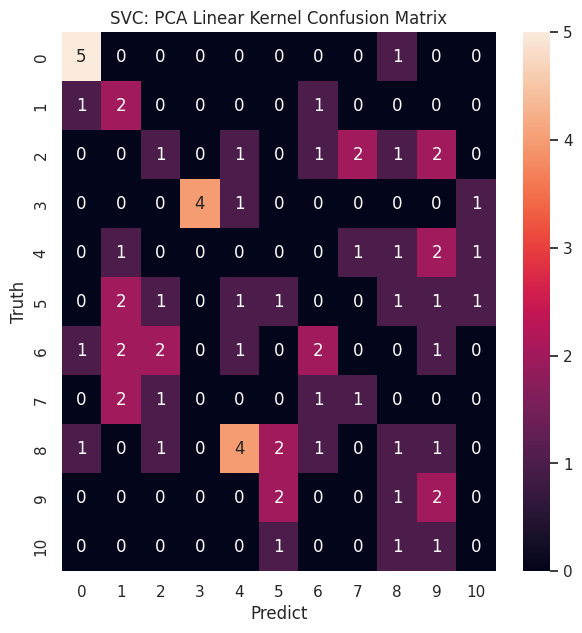

In [53]:
model_linear_pca = SVC(kernel = 'linear')
model_linear_pca.fit(X_train_pca, y_train_pca)
print('PCA Linear Model Test Score: ' + str(model_linear_pca.score(X_test_pca, y_test_pca)))

# Looking at the score of the training data vs. the test data for overfitting
print('PCA Linear Model Train Score: ' + str(model_linear_pca.score(X_train_pca, y_train_pca)))

y_pred_linear_pca = model_linear_pca.predict(X_test_pca)

precision_linear_pca = sm.precision_score(y_test_pca, y_pred_linear_pca, average = 'weighted')
print('PCA Linear Model Precision Score: ' + str(precision_linear_pca))
recall_linear_pca = sm.precision_score(y_test_pca, y_pred_linear_pca, average = 'weighted')
print('PCA Linear Model Recall Score: ' + str(recall_linear_pca))

print(classification_report(y_test_pca, y_pred_linear_pca, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test_pca, y_pred_linear_pca)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('SVC: PCA Linear Kernel Confusion Matrix')

**Step 16.1 Naive Bayes: Bernoulli Model**

>I think Naive Bayes was the next best after the RBF and the RandomForest models. It has an okay accuracy at 31% with precision, recall, and test score being at 30% and the train score at 38%. It definitely doesn't seem to be overfit. And everything just looks decent.

Bernoulli NB Model Test Score: 0.30985915492957744
Bernoulli NB Model Train Score: 0.38207547169811323
Bernoulli NB Model Precision Score: 0.30985915492957744
Bernoulli NB Model Recall Score: 0.30985915492957744
                         precision    recall  f1-score   support

          0.Chikungunya       0.50      0.83      0.62         6
               1.Dengue       0.25      0.25      0.25         4
2.Japanese_encephalitis       0.00      0.00      0.00         8
         3.Lyme_disease       0.57      0.67      0.62         6
              4.Malaria       0.20      0.33      0.25         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.33      0.22      0.27         9
            7.Tungiasis       0.50      1.00      0.67         5
      8.West_Nile_fever       0.00      0.00      0.00        11
         9.Yellow_fever       0.27      0.60      0.37         5
                10.Zika       0.00      0.00      0.00         3

      

Text(0.5, 1.0, 'Bernoulli NB Confusion Matrix')

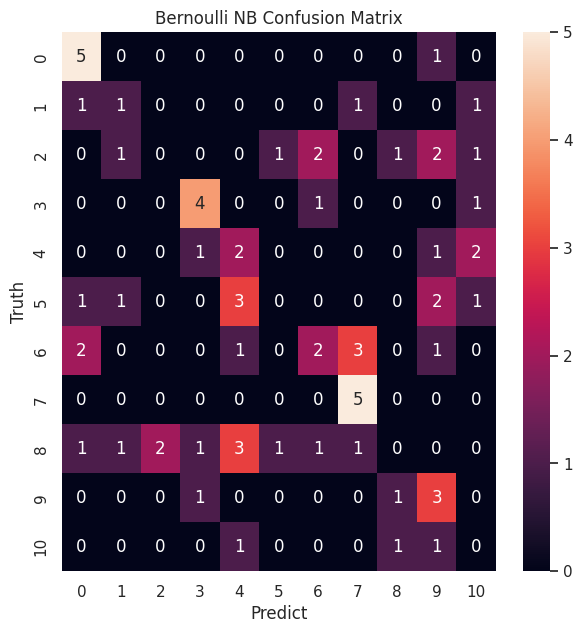

In [54]:
model_bnb = BernoulliNB()
model_bnb.fit(X_train, y_train)
print('Bernoulli NB Model Test Score: ' + str(model_bnb.score(X_test, y_test)))

# Looking at the score of the training data vs. the test data for overfitting
print('Bernoulli NB Model Train Score: ' + str(model_bnb.score(X_train, y_train)))

y_pred_bnb = model_bnb.predict(X_test)

precision_bnb = sm.precision_score(y_test, y_pred_bnb, average = 'micro')
print('Bernoulli NB Model Precision Score: ' + str(precision_bnb))
recall_bnb = sm.recall_score(y_test, y_pred_bnb, average = 'micro')
print('Bernoulli NB Model Recall Score: ' + str(recall_bnb))

print(classification_report(y_test, y_pred_bnb, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_bnb)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('Bernoulli NB Confusion Matrix')

**Step 16.2 PCA Naive Bayes: Bernoulli Model**

>PCA lowered the accuracy to 28% and increased the train score to 44% so the model is defintely not better with the PCA.

PCA Bernoulli NB Model Test Score: 0.28169014084507044
PCA Bernoulli NB Model Train Score: 0.44339622641509435
PCA Bernoulli NB Model Precision Score: 0.28169014084507044
PCA Bernoulli NB Model Recall Score: 0.28169014084507044
                         precision    recall  f1-score   support

          0.Chikungunya       0.56      0.83      0.67         6
               1.Dengue       0.00      0.00      0.00         4
2.Japanese_encephalitis       0.00      0.00      0.00         8
         3.Lyme_disease       0.67      0.67      0.67         6
              4.Malaria       0.18      0.33      0.24         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.00      0.00      0.00         9
            7.Tungiasis       0.33      0.60      0.43         5
      8.West_Nile_fever       0.20      0.18      0.19        11
         9.Yellow_fever       0.33      0.40      0.36         5
                10.Zika       0.25      0.67      0.36  

Text(0.5, 1.0, 'PCA Bernoulli NB Confusion Matrix')

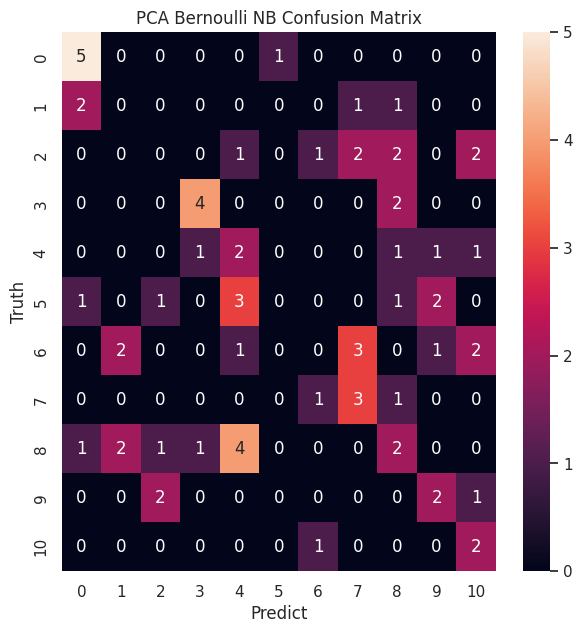

In [55]:
model_bnb_pca = BernoulliNB()
model_bnb_pca.fit(X_train_pca, y_train_pca)
print('PCA Bernoulli NB Model Test Score: ' + str(model_bnb_pca.score(X_test_pca, y_test_pca)))

# Looking at the score of the training data vs. the test data for overfitting
print('PCA Bernoulli NB Model Train Score: ' + str(model_bnb_pca.score(X_train_pca, y_train_pca)))

y_pred_bnb_pca = model_bnb_pca.predict(X_test_pca)

precision_bnb_pca = sm.precision_score(y_test_pca, y_pred_bnb_pca, average = 'micro')
print('PCA Bernoulli NB Model Precision Score: ' + str(precision_bnb_pca))
recall_bnb_pca = sm.recall_score(y_test_pca, y_pred_bnb_pca, average = 'micro')
print('PCA Bernoulli NB Model Recall Score: ' + str(recall_bnb_pca))

print(classification_report(y_test_pca, y_pred_bnb_pca, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test_pca, y_pred_bnb_pca)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('PCA Bernoulli NB Confusion Matrix')

**Step 17.1 KNearest Neighbors Model**

>I think the KNearest Neighbors model is not a good model given it's high false predictions. The accuracy score is 27% and the precision and recall are at 26% which I think is low compared to the other models. Test score is 26% and train score is at 30% so I don't think model is overfit but it was difficult to tune it so that it wasn't overfitting the train data.
>The 'weights=' input did not change the results much but 'n_neighbors=' did.

KNC Model Test Score: 0.2676056338028169
KNC Model Train Score: 0.3018867924528302
KNC Model Precision Score: 0.2676056338028169
KNC Model Recall Score: 0.2676056338028169
                         precision    recall  f1-score   support

          0.Chikungunya       0.21      0.83      0.33         6
               1.Dengue       0.00      0.00      0.00         4
2.Japanese_encephalitis       0.00      0.00      0.00         8
         3.Lyme_disease       0.50      0.67      0.57         6
              4.Malaria       0.33      0.33      0.33         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.00      0.00      0.00         9
            7.Tungiasis       0.56      1.00      0.71         5
      8.West_Nile_fever       0.00      0.00      0.00        11
         9.Yellow_fever       0.21      0.60      0.32         5
                10.Zika       0.00      0.00      0.00         3

               accuracy                       

Text(0.5, 1.0, 'KNeighbors Classifier Confusion Matrix')

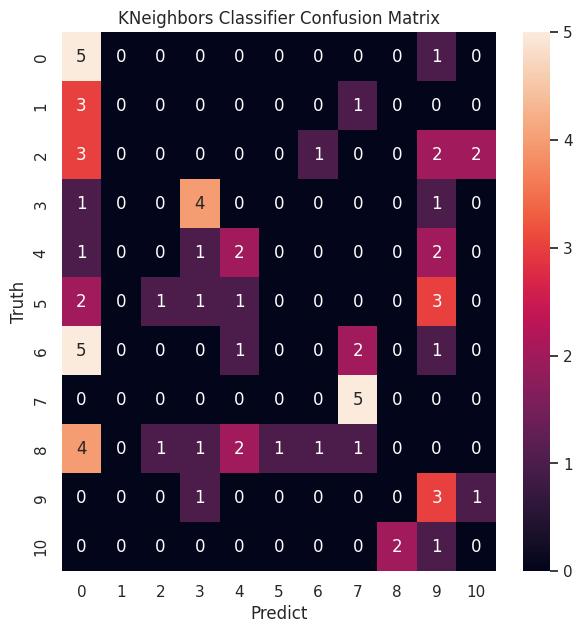

In [56]:
model_knc = KNeighborsClassifier(n_neighbors=50, weights='uniform')
model_knc.fit(X_train, y_train)
print('KNC Model Test Score: ' + str(model_knc.score(X_test, y_test)))

# Looking at the score of the training data vs. the test data for overfitting
print('KNC Model Train Score: ' + str(model_knc.score(X_train, y_train)))

y_pred_knc = model_knc.predict(X_test)

precision_knc = sm.precision_score(y_test, y_pred_knc, average = 'micro')
print('KNC Model Precision Score: ' + str(precision_knc))
recall_knc = sm.recall_score(y_test, y_pred_knc, average = 'micro')
print('KNC Model Recall Score: ' + str(recall_knc))

print(classification_report(y_test, y_pred_knc, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_knc)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('KNeighbors Classifier Confusion Matrix')

**Step 17.2 PCA KNearest Neighbors Model**

PCA marginally improved the accuracy % but the false predictions are still a large issue with this model.

PCA KNC Model Test Score: 0.28169014084507044
PCA KNC Model Train Score: 0.3050314465408805
PCA KNC Model Precision Score: 0.2676056338028169
PCA KNC Model Recall Score: 0.28169014084507044
                         precision    recall  f1-score   support

          0.Chikungunya       0.22      0.83      0.34         6
               1.Dengue       0.00      0.00      0.00         4
2.Japanese_encephalitis       0.00      0.00      0.00         8
         3.Lyme_disease       0.67      0.67      0.67         6
              4.Malaria       0.29      0.33      0.31         6
               5.Plague       0.00      0.00      0.00         8
    6.Rift_Valley_fever       0.00      0.00      0.00         9
            7.Tungiasis       0.50      1.00      0.67         5
      8.West_Nile_fever       0.33      0.09      0.14        11
         9.Yellow_fever       0.20      0.40      0.27         5
                10.Zika       0.33      0.33      0.33         3

               accuracy     

Text(0.5, 1.0, 'PCA KNeighbors Classifier Confusion Matrix')

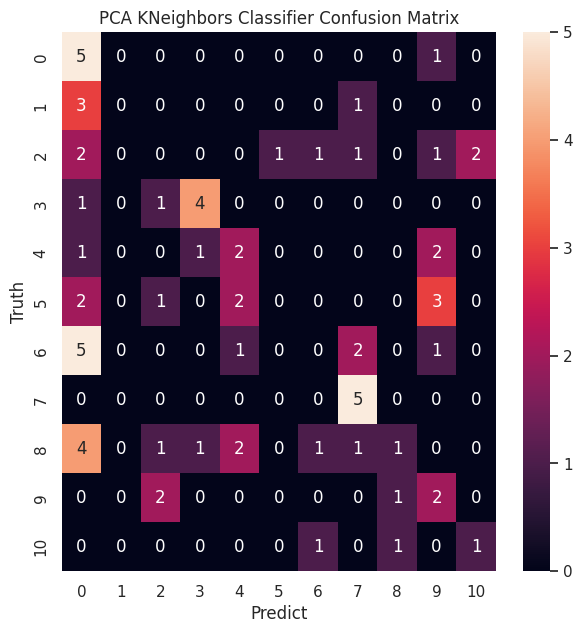

In [57]:
model_knc_pca = KNeighborsClassifier(n_neighbors=50, weights='uniform')
model_knc_pca.fit(X_train_pca, y_train_pca)
print('PCA KNC Model Test Score: ' + str(model_knc_pca.score(X_test_pca, y_test_pca)))

# Looking at the score of the training data vs. the test data for overfitting
print('PCA KNC Model Train Score: ' + str(model_knc_pca.score(X_train_pca, y_train_pca)))

y_pred_knc_pca = model_knc_pca.predict(X_test_pca)

precision_knc_pca = sm.precision_score(y_test_pca, y_pred_knc_pca, average = 'micro')
print('PCA KNC Model Precision Score: ' + str(precision_knc))
recall_knc_pca = sm.recall_score(y_test_pca, y_pred_knc_pca, average = 'micro')
print('PCA KNC Model Recall Score: ' + str(recall_knc_pca))

print(classification_report(y_test_pca, y_pred_knc_pca, zero_division=0, target_names=target_names))

cm = sm.confusion_matrix(y_test, y_pred_knc_pca)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predict')
plt.ylabel('Truth')
plt.title('PCA KNeighbors Classifier Confusion Matrix')

**Step 18: Predictions**

In the kaggle competition (https://www.kaggle.com/competitions/playground-series-s3e13) participants were tasked with predicting the prognosis of each id in the 'test.csv' file. I went ahead and did that based on what model I thought was best. So, below I have the RBF kernel model and added the 'test.csv' data in there to predict my new y-value. Then I did a 'for' loop to add those predictions to a new df after using a dictionary to change the encoded prognosis values back to their original names.

In [58]:
# Putting together the test competition data
model_rbf = SVC(kernel='rbf', random_state=42)
model_rbf.fit(X_train, y_train)
y_pred_rbf_comp = model_rbf.predict(X_data)
new_ids = []

# show the inputs and predicted outputs
for i in y_pred_rbf_comp:
    new_ids.append(
      {
      'prognosis' : i
      }
  )

prognosis_pred = pd.DataFrame(new_ids, columns = ['prognosis'])
test_data = pd.concat([X_data_id, prognosis_pred], axis = 1)

test_data.prognosis.replace({0:'Chikungunya', 1:'Dengue', 2:'Japanese_encephalitis', 3:'Lyme_disease', 4:'Malaria', 5:'Plague', 6:'Rift_Valley_fever', 7:'Tungiasis', 8:'West_Nile_fever', 9:'Yellow_fever', 10:'Zika'}, inplace=True)

In [59]:
# My competition results / prediction the 'test.csv' data with my chosen model: SVC RBF kernel
test_data

,id,prognosis
0,707,Rift_Valley_fever
1,708,Dengue
2,709,West_Nile_fever
3,710,Japanese_encephalitis
4,711,West_Nile_fever
...,...,...
298,1005,Zika
299,1006,Malaria
300,1007,Lyme_disease
301,1008,West_Nile_fever


**Step 19: Conclusion**

>In conclusion, I think that my data rendered generally low precision, recall, and accuracy scores for all the models. However, I think that is reflective of biological data since it tends to be more "messy" and less predictable. I ended up choosing to predict with the RBF kernel but the RandomForest may have actually been the better model to use since it may have been less "overfit" in comparison despite the lower accuracy score.

>Further research of PCA indicates it is an unsupervised learning technique and therefore, that most likely explains the consistently poor results on all of my models as they then had less features to interpret and be trained on.

>All in all, my results demonstrate the ability to train a machine learning model to predict a prognosis for a vector-borne disease given a random set of particular symptoms. This model can be used to help healthcare facilities to be able to screen patient symptoms and thereby helping decrease healthcare provider caseloads.